In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json
import matplotlib.pyplot as plt

In [2]:
class CarDataset(Dataset):
    def __init__(self, file_path, root_dir, transform=None):
        """
        Args:
            file_path (str): Path to the text file containing image paths.
            root_dir (str): Root directory containing the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_paths = []
        self.labels = []
        self.root_dir = root_dir
        self.transform = transform

        # Load image paths and labels
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    # Extract label (first number in the path)
                    label = int(line.split('/')[1])
                    self.labels.append(label)
                    self.image_paths.append(os.path.join(root_dir, line))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Directories and file paths
train_file_path = "/data/NNDL/data/train_test_split/classification/train.txt"
test_file_path = "/data/NNDL/data/train_test_split/classification/test.txt"
root_dir = "/data/NNDL/data/image/"

### Resnet

In [4]:
# Data augmentation and normalization for training and validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(15),  # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random changes in brightness, contrast, etc.
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.RandomGrayscale(p=0.1),  # Randomly convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

In [5]:
# Create the dataset
train_val_dataset = CarDataset(train_file_path, root_dir, transform=transform)
test_dataset = CarDataset(test_file_path, root_dir, transform=transform)

# Aggregate all labels from the datasets
all_labels = set(train_val_dataset.labels + test_dataset.labels)

# Check labels in all datasets
print(f"Min label: {min(all_labels)}, Max label: {max(all_labels)}")
print(f"Expected label range: [0, {len(all_labels) - 1}]")


# Split train/validation set (80% train, 20% validation)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

Min label: 1, Max label: 1993
Expected label range: [0, 430]


In [6]:
# Create a mapping for labels to 0-based indices
label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
train_val_dataset.labels = [label_to_idx[label] for label in train_val_dataset.labels]
test_dataset.labels = [label_to_idx[label] for label in test_dataset.labels]

# Update the number of classes
num_classes = len(label_to_idx)


In [7]:
# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [8]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 12812
Validation dataset size: 3204
Test dataset size: 14939


In [9]:
# Load a pre-defined model structure (ResNet without pretrained weights)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Adjust for the number of classes

/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
# Load the best model
model.load_state_dict(torch.load('model_predictor_resnet50_model.pth'))
model.eval()

# Test the model on the test dataset
running_corrects = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        running_corrects += (preds == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = running_corrects / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")


/tmp/ipykernel_903444/2101938057.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_predictor_resnet50_model.pth'))


Test Accuracy: 0.6746


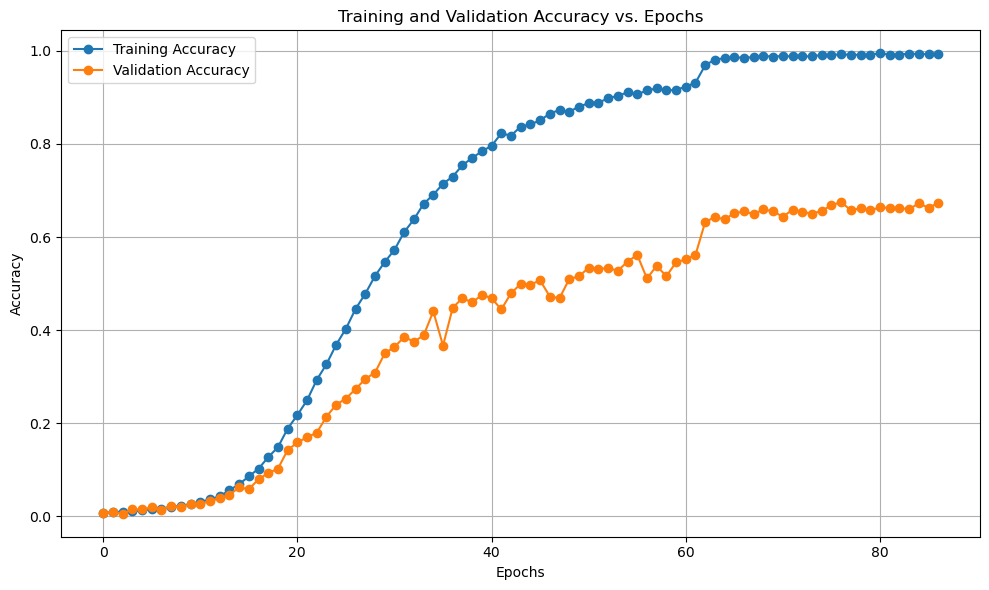

In [12]:
# Load the accuracy data
with open('model_predictor_resnet50_training.json', 'r') as f:
    data = json.load(f)

train_accuracies = data['train_accuracies']
val_accuracies = data['val_accuracies']

# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot to a file and show it
plt.savefig('model_predictor_resnet50_training_plot.png')
plt.show()


### Inception

In [13]:
# Data augmentation and normalization for training and validation
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(15),  # Random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random changes in brightness, contrast, etc.
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.RandomGrayscale(p=0.1),  # Randomly convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

In [14]:
# Create the dataset
train_val_dataset = CarDataset(train_file_path, root_dir, transform=transform)
test_dataset = CarDataset(test_file_path, root_dir, transform=transform)

# Aggregate all labels from the datasets
all_labels = set(train_val_dataset.labels + test_dataset.labels)

# Check labels in all datasets
print(f"Min label: {min(all_labels)}, Max label: {max(all_labels)}")
print(f"Expected label range: [0, {len(all_labels) - 1}]")


# Split train/validation set (80% train, 20% validation)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

Min label: 1, Max label: 1993
Expected label range: [0, 430]


In [15]:
# Create a mapping for labels to 0-based indices
label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
train_val_dataset.labels = [label_to_idx[label] for label in train_val_dataset.labels]
test_dataset.labels = [label_to_idx[label] for label in test_dataset.labels]

# Update the number of classes
num_classes = len(label_to_idx)


In [16]:
# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [17]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 12812
Validation dataset size: 3204
Test dataset size: 14939


In [18]:
model = models.inception_v3(pretrained=True, aux_logits=True)  # Use Inception-v3
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Adjust the final layer for your number of classes

/data/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [20]:
# Load the best model
model.load_state_dict(torch.load('model_predictor_inception_model.pth'))
model.eval()

# Test the model on the test dataset
running_corrects = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        running_corrects += (preds == labels).sum().item()
        total_samples += labels.size(0)

test_accuracy = running_corrects / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")


/tmp/ipykernel_903444/2482857155.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_predictor_inception_model.pth'))


Test Accuracy: 0.0102


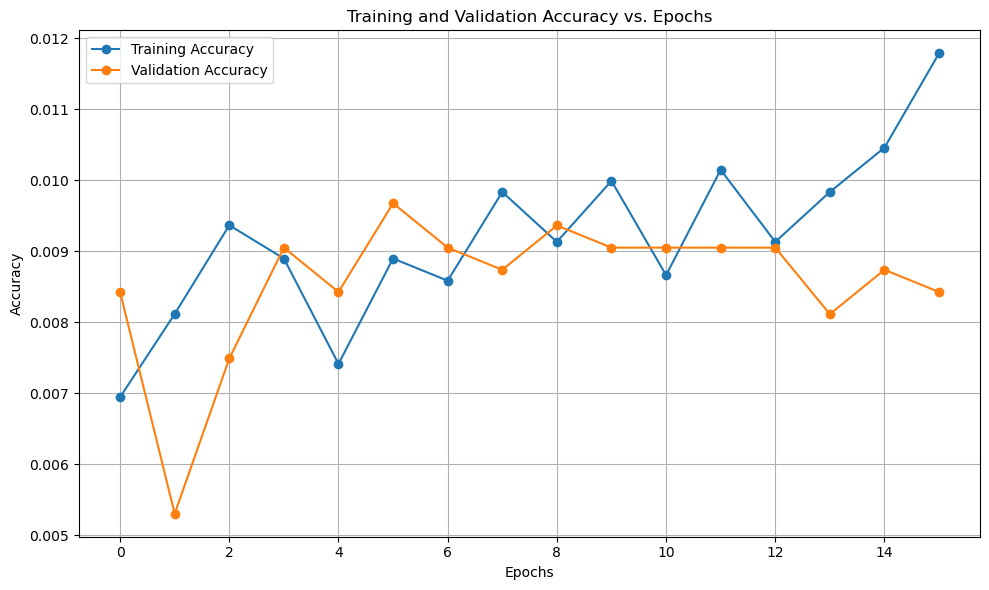

In [21]:
# Load the accuracy data
with open('model_predictor_inception_training.json', 'r') as f:
    data = json.load(f)

train_accuracies = data['train_accuracies']
val_accuracies = data['val_accuracies']

# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot to a file and show it
plt.savefig('model_predictor_inception_training_plot.png')
plt.show()
